In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl
from params_est import optim_step_ICP

In [3]:
ksize = 10
depth_dir = f'../data/synthetic/stylized-ww01-plane/blender_renders_depth4_3x_more_frames_mblur_{ksize}/'
gt_extrinsics_dir = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/'
gt_depth_dir = '../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_'
shared_K_path = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/K_0.txt'

In [4]:
K = torch.tensor(np.loadtxt(shared_K_path)).double()

In [5]:
K

tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64)

In [6]:
def load_data(depth_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, RT_all, gt_depth_all = [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    RT_all = torch.tensor(np.stack(RT_all)).double()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, RT_all, gt_depth_all
    return depth_all, RT_all

In [7]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)

In [8]:
depth[0].min(), depth[0].max()

(tensor(6.1587, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [9]:
depth[1].min(), depth[1].max()

(tensor(6.2128, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [10]:
depth.shape, extr.shape, gt_depth.shape

(torch.Size([2, 1080, 1920]),
 torch.Size([2, 4, 4]),
 torch.Size([2, 1080, 1920]))

### Testing visualization

In [11]:
pc1 = Cloud.from_tensors(depth[0], K, extr[0], ignore='max')

In [12]:
pc1.points

tensor([[ 1.6526, -0.7546, 14.1700],
        [ 1.6093, -0.7325, 13.7550],
        [ 1.5657, -0.7103, 13.3393],
        ...,
        [ 0.0976,  1.6636, 13.0099],
        [ 0.1087,  1.7655, 13.8064],
        [ 0.1205,  1.8673, 14.6023]], dtype=torch.float64)

In [14]:
def visualize_pcd(*cloud_objs):
    all_pc_o3d = []
    for cloud in cloud_objs:
        cloud_pts = cloud.points.cpu().data.numpy()
        pc_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cloud_pts))
        all_pc_o3d.append(pc_o3d)
    o3d.visualization.draw_geometries(all_pc_o3d)

In [15]:
visualize_pcd(pc1)

### Testing params estimation (ICP correspondence set till convergence + LM till convergence)

In [38]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)

In [39]:
# pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [40]:
visualize_pcd(pc0, pc1)

In [41]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

  0%|          | 0/100 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...


  0%|          | 0/100 [00:01<?, ?it/s]


tensor([-1.8034,  0.0841, -0.0755,  0.0127,  0.2649,  0.0294],
       dtype=torch.float64)

In [42]:
visualize_pcd(pc0, pc1)

In [35]:
transl

tensor([-0.3203,  0.5003,  0.1535], dtype=torch.float64)

In [43]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9647, -0.0274,  0.2620, -1.8034],
        [ 0.0307,  0.9995, -0.0087,  0.0841],
        [-0.2616,  0.0164,  0.9650, -0.0755],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [44]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### Testing params estimation ((ICP correspondence set 1 iteration + LM 1 iteration) x N_iter)

In [ ]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)

In [ ]:
# pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [ ]:
visualize_pcd(pc0, pc1)

In [41]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

  0%|          | 0/100 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...


  0%|          | 0/100 [00:01<?, ?it/s]


tensor([-1.8034,  0.0841, -0.0755,  0.0127,  0.2649,  0.0294],
       dtype=torch.float64)

In [42]:
visualize_pcd(pc0, pc1)

In [35]:
transl

tensor([-0.3203,  0.5003,  0.1535], dtype=torch.float64)

In [43]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9647, -0.0274,  0.2620, -1.8034],
        [ 0.0307,  0.9995, -0.0087,  0.0841],
        [-0.2616,  0.0164,  0.9650, -0.0755],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [44]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### GradOdometry

In [45]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
# depth = depth.requires_grad_()
depth_first = depth[0].clone()
depth_second = depth[1].clone()
_ = depth_first.requires_grad_()

In [46]:
depth.shape

torch.Size([2, 1080, 1920])

In [66]:
pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [67]:
gt_pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
gt_pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [69]:
# pc0.mask = gt_pc0.mask
# pc1.mask = gt_pc1.mask
# pc0.update_data(pc0.depth, pc0.intrinsic, pc0.extrinsic, update_mask=False)
# pc0.update_data(pc1.depth, pc1.intrinsic, pc1.extrinsic, update_mask=False)

In [70]:
visualize_pcd(pc0, pc1)

In [49]:
def loss(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val




  0%|          | 0/30 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...


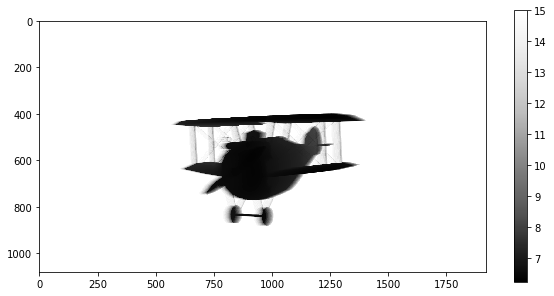




  3%|▎         | 1/30 [00:31<15:06, 31.24s/it]

L1 between depth_first pic with motion blur and GT: 0.09408603248032148
Correspondence set estimation...
Extrinsics estimation...


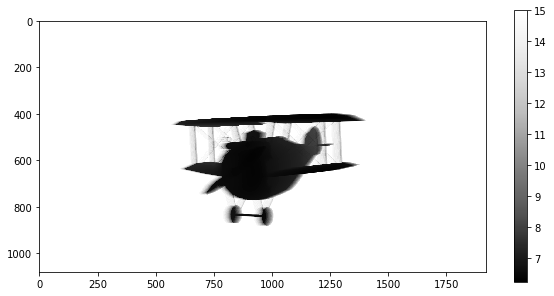




  7%|▋         | 2/30 [01:02<14:31, 31.14s/it]

L1 between depth_first pic with motion blur and GT: 0.09409160784663591
Correspondence set estimation...
Extrinsics estimation...


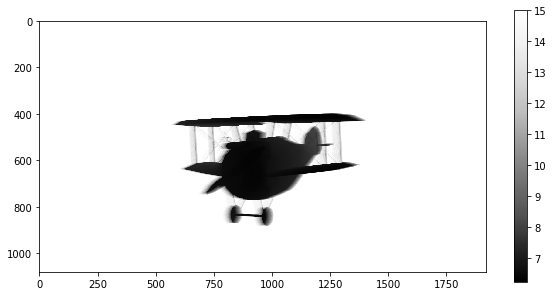




 10%|█         | 3/30 [01:32<13:54, 30.89s/it]

L1 between depth_first pic with motion blur and GT: 0.09409718361213627
Correspondence set estimation...
Extrinsics estimation...


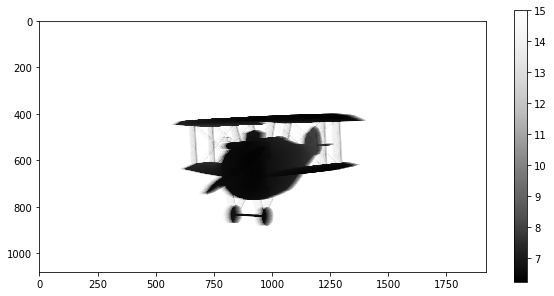




 13%|█▎        | 4/30 [02:01<13:07, 30.30s/it]

L1 between depth_first pic with motion blur and GT: 0.09410275975071013
Correspondence set estimation...
Extrinsics estimation...


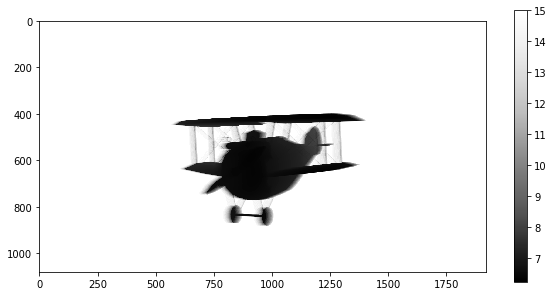




 17%|█▋        | 5/30 [02:32<12:42, 30.49s/it]

L1 between depth_first pic with motion blur and GT: 0.0941083359570619
Correspondence set estimation...
Extrinsics estimation...


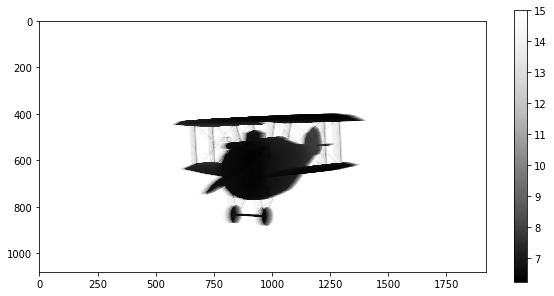




 20%|██        | 6/30 [03:03<12:17, 30.71s/it]

L1 between depth_first pic with motion blur and GT: 0.09411391200984659
Correspondence set estimation...
Extrinsics estimation...


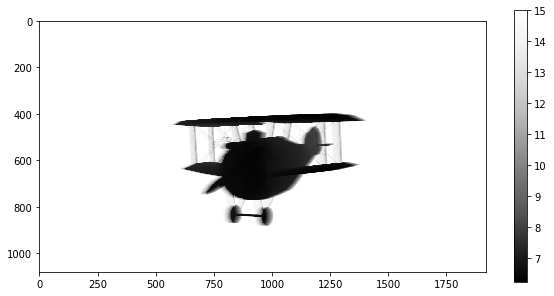




 23%|██▎       | 7/30 [03:39<12:23, 32.33s/it]

L1 between depth_first pic with motion blur and GT: 0.09411948808269831
Correspondence set estimation...
Extrinsics estimation...


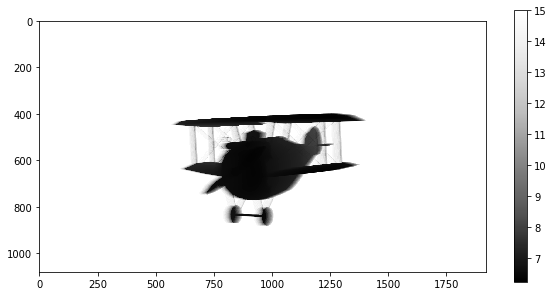




 27%|██▋       | 8/30 [04:08<11:29, 31.35s/it]

L1 between depth_first pic with motion blur and GT: 0.09412506454979222
Correspondence set estimation...
Extrinsics estimation...


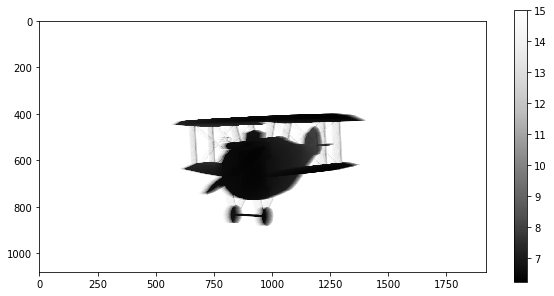




 30%|███       | 9/30 [04:36<10:36, 30.32s/it]

L1 between depth_first pic with motion blur and GT: 0.09413064152989391
Correspondence set estimation...
Extrinsics estimation...


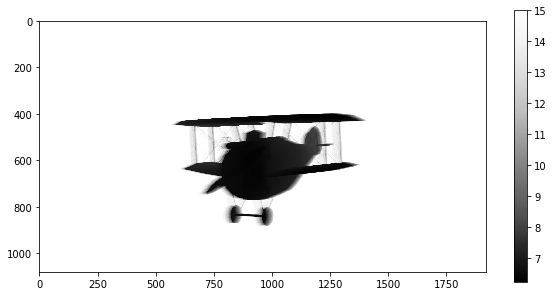




 33%|███▎      | 10/30 [05:04<09:49, 29.46s/it]

L1 between depth_first pic with motion blur and GT: 0.09413621828897113
Correspondence set estimation...
Extrinsics estimation...


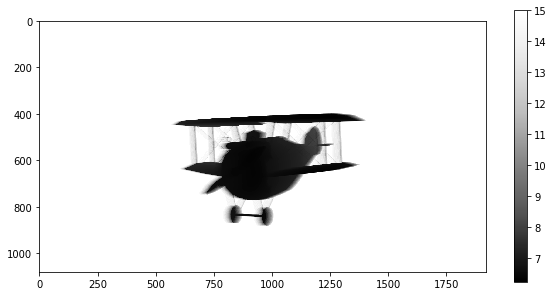




 37%|███▋      | 11/30 [05:31<09:08, 28.87s/it]

L1 between depth_first pic with motion blur and GT: 0.09414179500693473
Correspondence set estimation...
Extrinsics estimation...


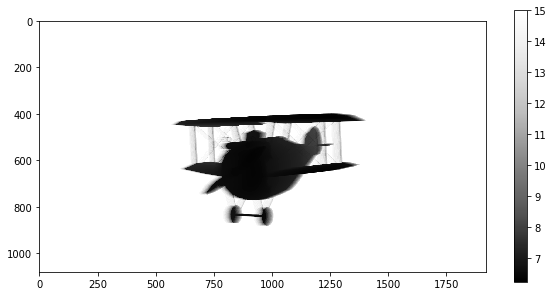




 40%|████      | 12/30 [05:58<08:30, 28.37s/it]

L1 between depth_first pic with motion blur and GT: 0.09414737168315579
Correspondence set estimation...
Extrinsics estimation...


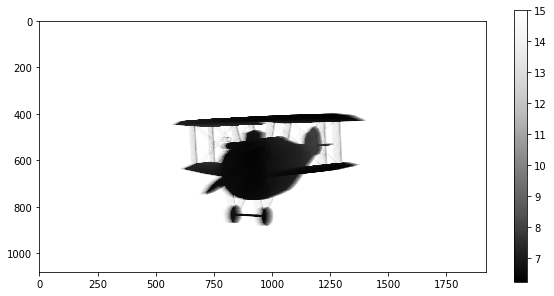




 43%|████▎     | 13/30 [06:26<08:01, 28.32s/it]

L1 between depth_first pic with motion blur and GT: 0.09415294832660683
Correspondence set estimation...
Extrinsics estimation...


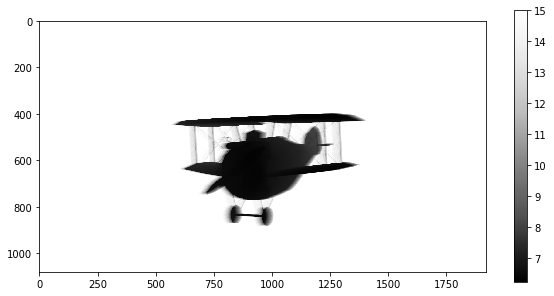




 47%|████▋     | 14/30 [06:54<07:30, 28.13s/it]

L1 between depth_first pic with motion blur and GT: 0.09415852446197004
Correspondence set estimation...
Extrinsics estimation...


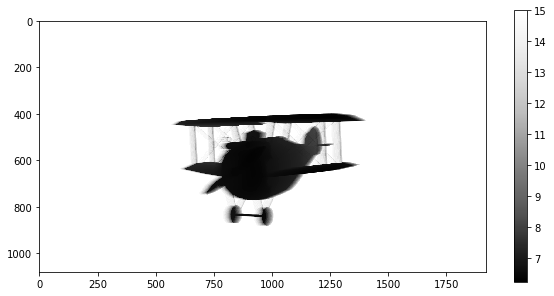




 50%|█████     | 15/30 [07:22<07:01, 28.07s/it]

L1 between depth_first pic with motion blur and GT: 0.0941641001667985
Correspondence set estimation...
Extrinsics estimation...


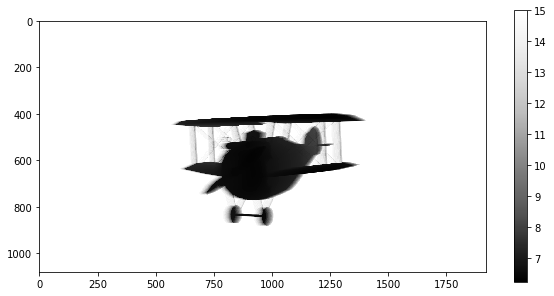




 53%|█████▎    | 16/30 [07:50<06:32, 28.03s/it]

L1 between depth_first pic with motion blur and GT: 0.09416967635882234
Correspondence set estimation...
Extrinsics estimation...


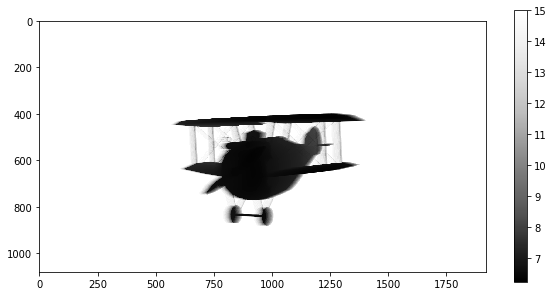




 57%|█████▋    | 17/30 [08:18<06:03, 27.98s/it]

L1 between depth_first pic with motion blur and GT: 0.09417525248063405
Correspondence set estimation...
Extrinsics estimation...


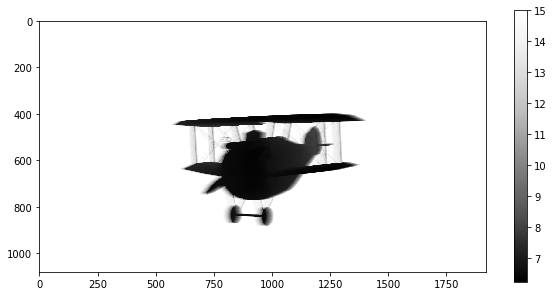




 60%|██████    | 18/30 [08:46<05:36, 28.05s/it]

L1 between depth_first pic with motion blur and GT: 0.09418082818783519
Correspondence set estimation...
Extrinsics estimation...


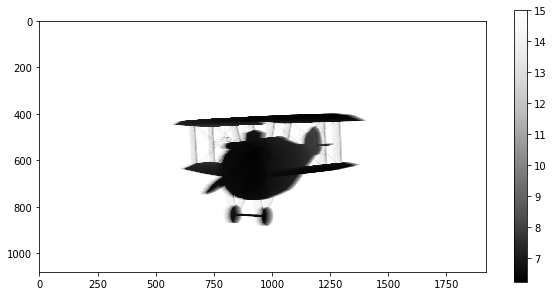




 63%|██████▎   | 19/30 [09:14<05:09, 28.13s/it]

L1 between depth_first pic with motion blur and GT: 0.0941864033996083
Correspondence set estimation...
Extrinsics estimation...


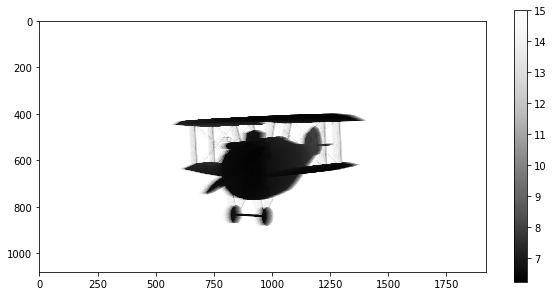




 67%|██████▋   | 20/30 [09:47<04:54, 29.43s/it]

L1 between depth_first pic with motion blur and GT: 0.09419197792377962
Correspondence set estimation...


KeyboardInterrupt: 

In [61]:
gradslam_iter = 30

opt = optim.Adam([depth_first], lr=1e-4)

depth_history = []
for i in tqdm(range(gradslam_iter)):
    pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
    pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
    
    #TODO do several iterations of this with small icp_max_iter:
    params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=10)
    transl, angle = params.split([3, 3], dim=-1)
    rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
    pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1) 
    T = extrinsics_from_rot_transl(rot, transl)
    
    opt.zero_grad()
    loss_val = loss(T, extr[0], extr[1])
    loss_val.backward()
    opt.step()
    
#     if i % 5 == 0:
#         visualize_pcd(pc0, pc1)
    
    depth_first_img = depth_first.cpu().data.numpy()
    depth_first_img_gt = gt_depth[0].cpu().data.numpy()
    depth_history.append(depth_first_img)
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
    plt.colorbar()
    plt.show()
    print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))

In [59]:
depth_first.min(), depth_first.max()

(tensor(6.2337, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [60]:
depth_first_img_gt.min(), depth_first_img_gt.max()

(6.15234375, 15.0)

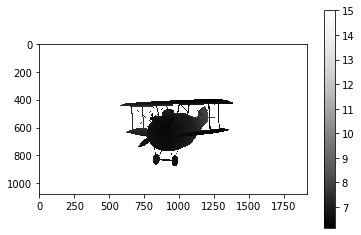

In [56]:
plt.imshow(depth_first_img_gt, cmap=plt.cm.Greys_r)
plt.colorbar()